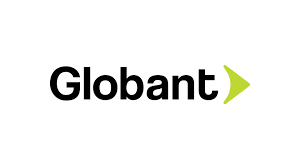

# Test DS Globant - Camilo Rubio, 2025 

## Importing libraries and reading inputs 

In [1]:
# Importing Python Libraries 

#For basic operations
import sys, os
import pandas as pd
import numpy as np
import warnings
import time

# For data import
import kagglehub
from read_dataset import read_file

#For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import shap

#For data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#For data splitting
from sklearn.model_selection import train_test_split

#For model execution, storage and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from modelling import build_keras_model, train_and_evaluate_model, select_best_model, get_objective, plot_feature_importances_or_shap, run_cross_validation

from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_auc_score, 
                             roc_curve, precision_recall_curve, auc, brier_score_loss)
from sklearn.calibration import calibration_curve, CalibrationDisplay
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
import pickle

#For model tuning
import optuna

#For model saving
import pickle

#For model loading
from joblib import load

# For EDA
from preprocessing import exploratory_basics, preprocessing_EDA_and_charts, ultimate_preprocessing

# For feature engineering
from feature_engineering import new_features

warnings.filterwarnings("ignore")

In [2]:
# Read DataFrame with already-defined function that delete totally duplicated records and records with no values at all
df = read_file()
df.head(2)

INFO:root:Path to dataset files: C:\Users\camilorubio\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1
INFO:root:File read successfully


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


## Data Preprocessing and EDA

In [3]:
# Bring Basics Analysis
EDA = exploratory_basics(df)

print(EDA)

Exploratory Data Analysis
Number of rows:  7043
Number of columns:  21
Summary statistics:         SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000
Column names:  Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries

Preliminar Conclusions: 
* Total Charges should be numerical
* There isn't null values in any column, but could be in the future. To handle eventual missing values, we're charging null values with mean/median for numerical columns and drop them for the rest of the cases (NOTE: We could also impute the mode for missing values in categorical columns but for simplicity we're just going to drop them).

INFO:root:Total Charges converted to numeric
INFO:root:Columns divided into numerical and categorical
INFO:root:Numerical columns with null values filled with median
INFO:root:Records with null categorical values dropped
INFO:root:Columns with a single category dropped


Unique values in categorical columns: 
customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
--------------------------------------------------
gender ['Female' 'Male']
--------------------------------------------------
SeniorCitizen ['0' '1']
--------------------------------------------------
Partner ['Yes' 'No']
--------------------------------------------------
Dependents ['No' 'Yes']
--------------------------------------------------
PhoneService ['No' 'Yes']
--------------------------------------------------
MultipleLines ['No phone service' 'No' 'Yes']
--------------------------------------------------
InternetService ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSecurity ['No' 'Yes' 'No internet service']
--------------------------------------------------
OnlineBackup ['Yes' 'No' 'No internet service']
--------------------------------------------------
DeviceProtection ['No' 'Yes' 'No internet servic

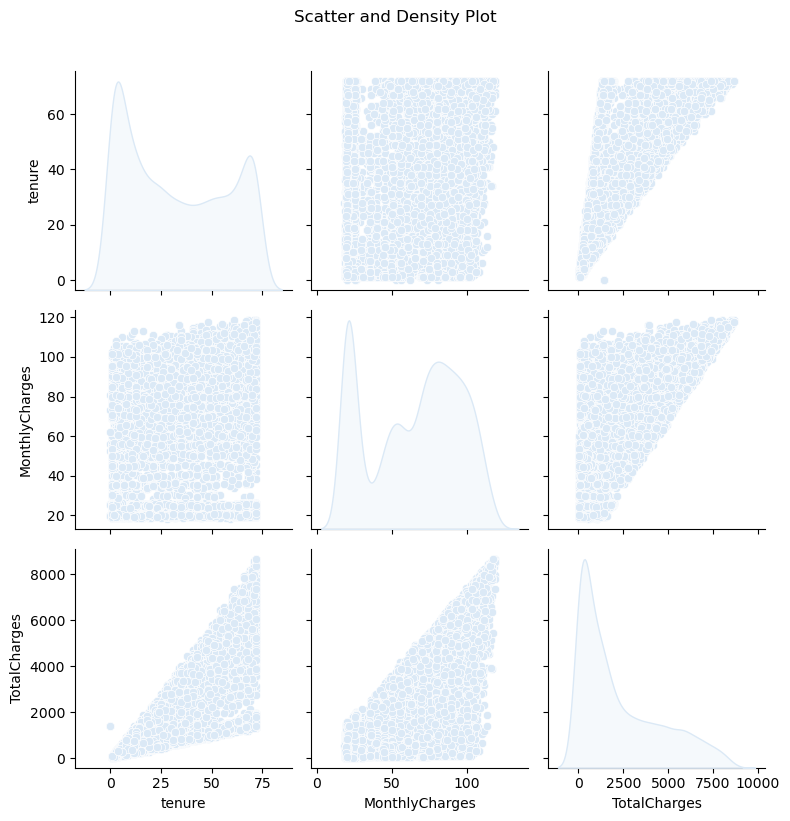

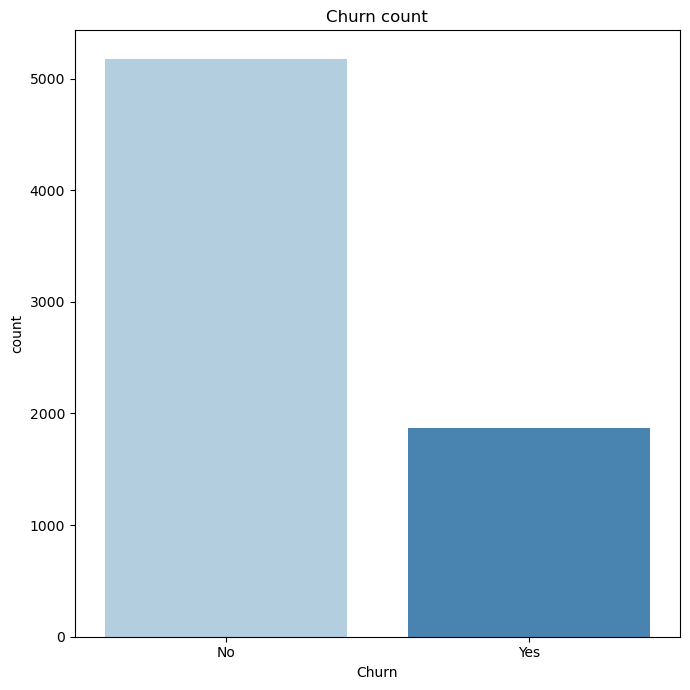

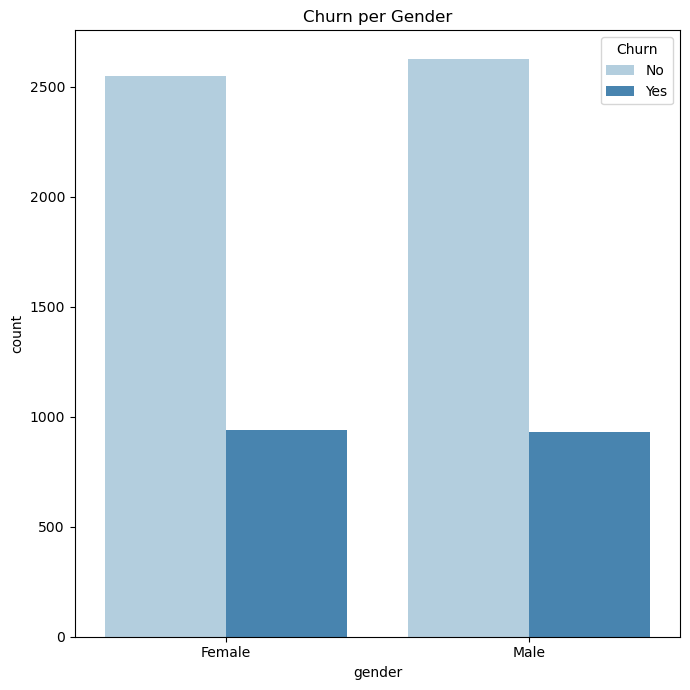

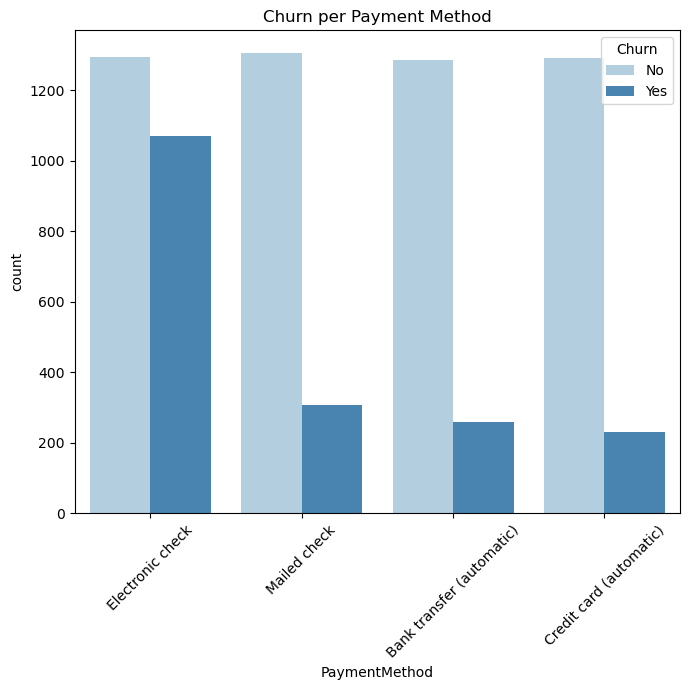

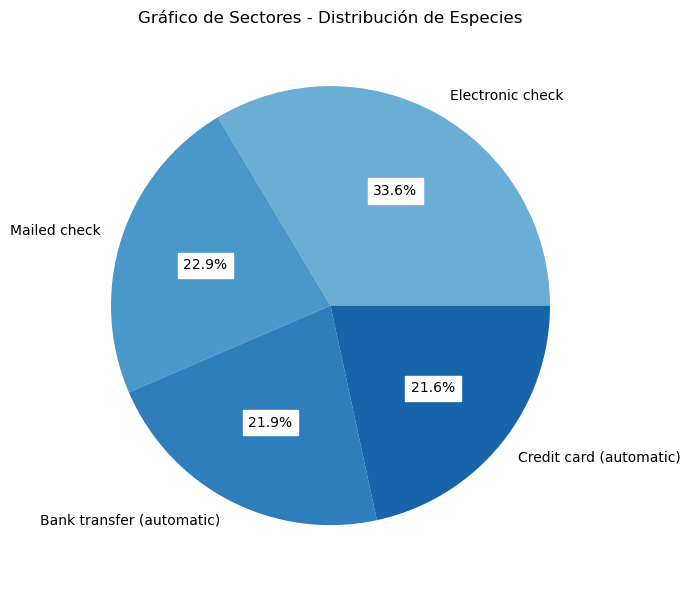

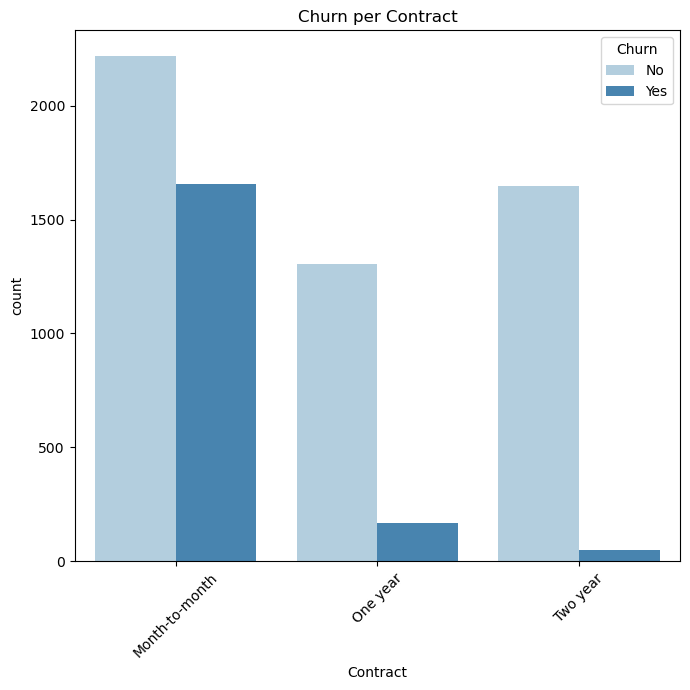

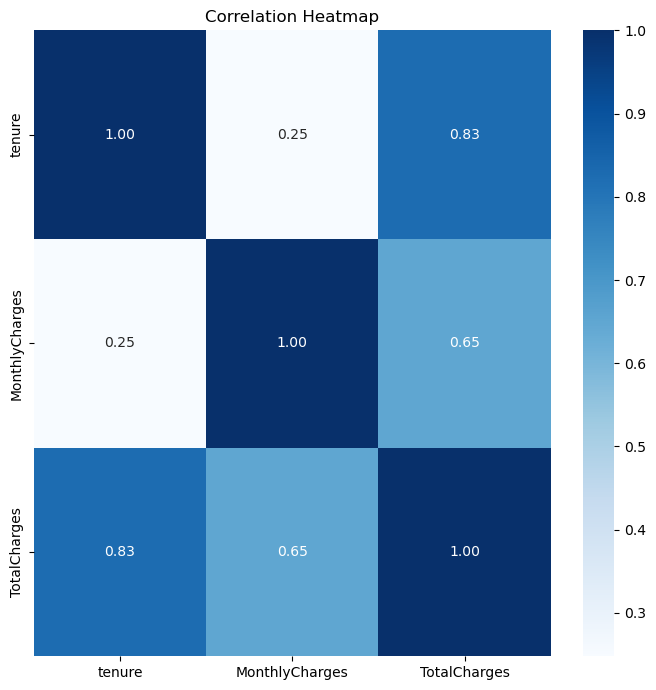

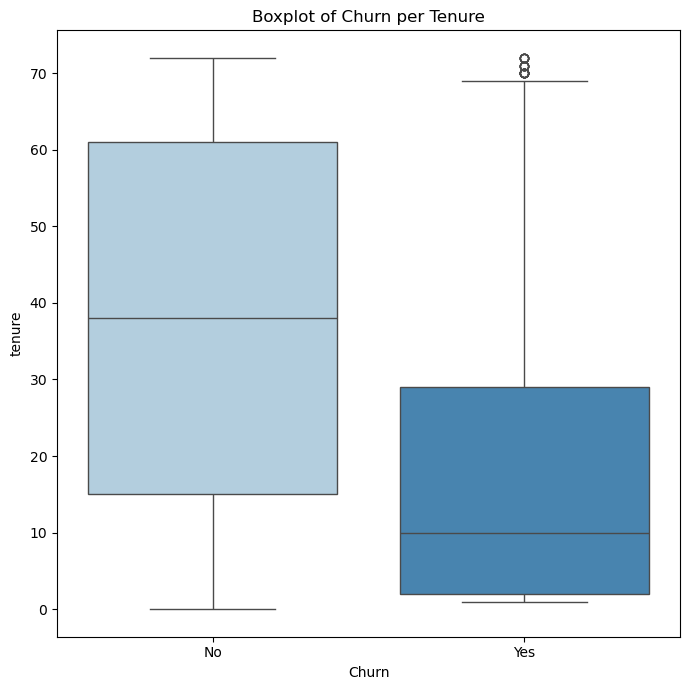

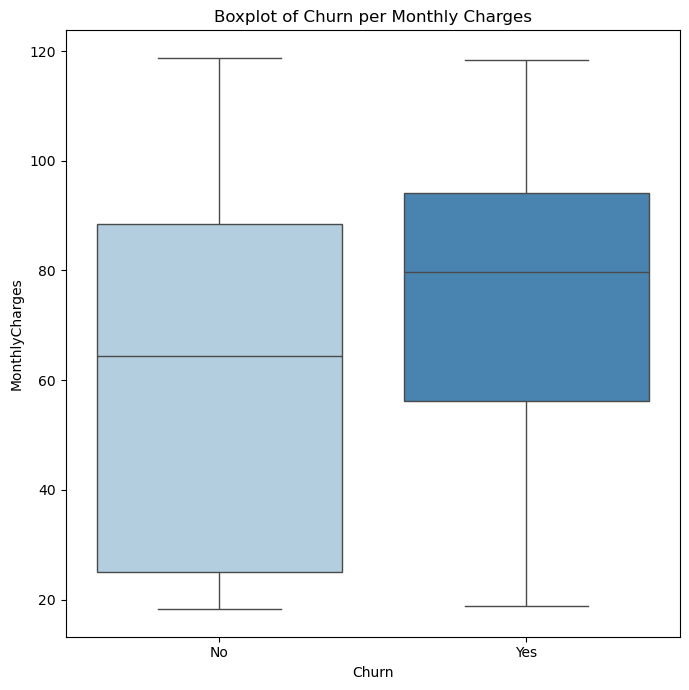

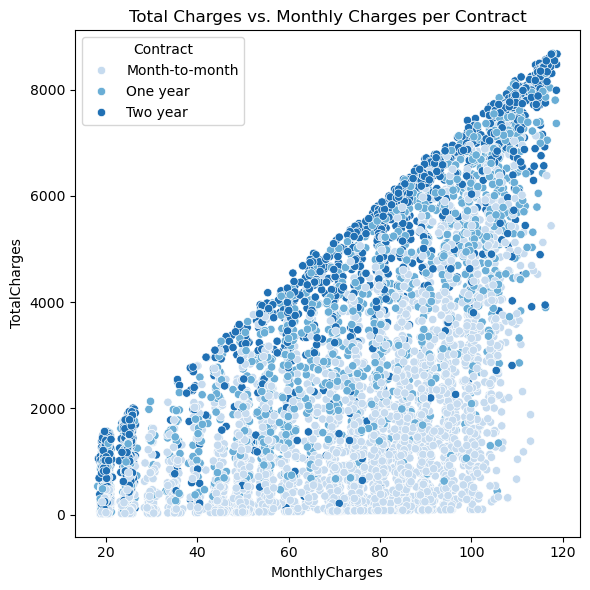

In [4]:
# Bring Preprocessing EDA
df_preprocessed, categorical_features, numerical_features = preprocessing_EDA_and_charts(df, 8)

Conclusions
* Is more usual to see high monthly charges end up in Churn
* As tenure increases is less usual to have churn (probably due to habits and brand loyalty)
* A weird high proportion of clients who payed via Electronic check end up in churn
* Same happens with month-to-month payers. Usually when customers pay for a month-to-month subscription, they have more freedom to cancel their service at any time without facing large penalties or long-term commitments. Then lower barrier exists in this case.
* Data is unbalanced, so we should either take care of the metrics used (mainly avoiding accuracy) or apply some balance methods. Initially we're applying SMOTE to increase a little bit the minority class to make train proportion to be 60%-40%.

In [5]:
X, y, X_train, X_test, y_train, y_test, X_res, y_res, X_train_pre = ultimate_preprocessing(df_preprocessed, numerical_features, categorical_features)

INFO:root:CustomerID column dropped
INFO:root:Dataset splitted into X and y
INFO:root:Dataset splitted into train and test
INFO:root:Numerical columns scaled
INFO:root:Categorical dependent column encoded
INFO:root:Dataset partially balanced with SMOTE


## Feature Engineering


- **Logics:**
  - Because the type of payment and contract seem to impact churn, we'll create an interaction feature between payment and contract.
  - We'll also generate a new feature called `Charges_tenure` that measures the relationship between total charges and tenure. This ratio may reveal customers who, despite having a high investment (`TotalCharges`), have a short relationship period (tenure), which could indicate dissatisfaction or risk of churn.
  - We'll generate a new feature called `Family` which stands for 1 in case both Partner and Dependents are True.
  - Finally, we will create a new feature named `Client_Segment` which follows this logic:
    - If the client has a tenure < 12 months, we will tag them as **New**.
    - If the client's tenure is between 12 and 24 months, we will tag them as **Medium**.
    - If a client has a tenure > 24 months but monthly charges under the mean of all clients, we tag them as **Loyal**.
    - If a client has a tenure > 24 months and monthy charges over the mean of all clients, we tag them as **Top Loyal**.
    
    After making this segmentation, we'll apply ordinal encoding to this last feature.


NOTE: Because this new variables can generate some multicollinearity issues we're using XGBoost, Random Forest and Neural Networks due to their capacity to handle this problems (i.e. using regularization and Dropout) 


In [6]:
X_train_res, X_test = new_features(X_res, X_test, X_train_pre)

INFO:root:Feature interaction PaymentContract created
INFO:root:Feature interaction Charges_Tenure created
INFO:root:Feature Family created
INFO:root:Feature Client_Segment created


## Model Execution

We are going to try three different models: Random Forest, XGBoost, and Neural Networks.

Since we do not know how costly it might be to intervene to retain a customer, we will assume that the cost of inaction is probably higher than the cost of applying retention measures to a customer who is not at risk of churn. Therefore, we prioritize recall and apply the SMOTE technique to achieve a balance of 60% for class 0 and 40% for class 1. This adjustment significantly increased recall while precision decreased only slightly. However, recall will not be used as a criterion for selecting the best model; because the data remains unbalanced, we will consider the F1 Score, Brier Score, and especially the ROC-AUC as the primary metrics for selecting the best model, rather than relying solely on accuracy. The ROC-AUC curve will serve as the key metric when optimizing the model. The reason is that this metric evaluates the true positive rate against the false positive rate across all possible decision thresholds, measures the model's ability to assign higher probabilities to positive cases compared to negative ones, and is insensitive to class imbalance.

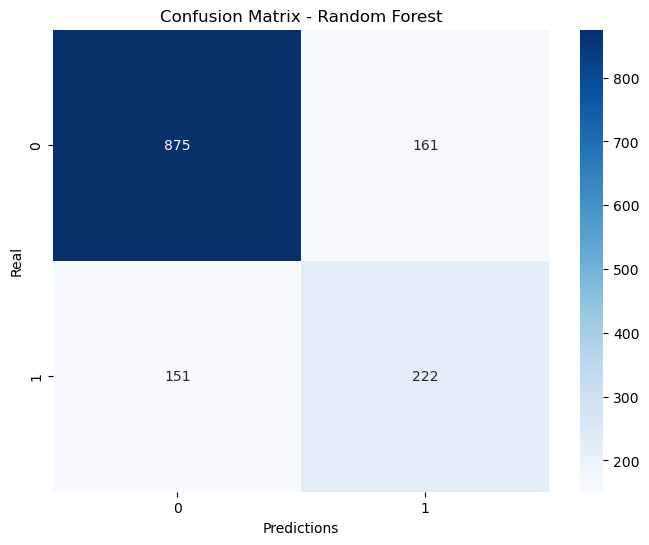

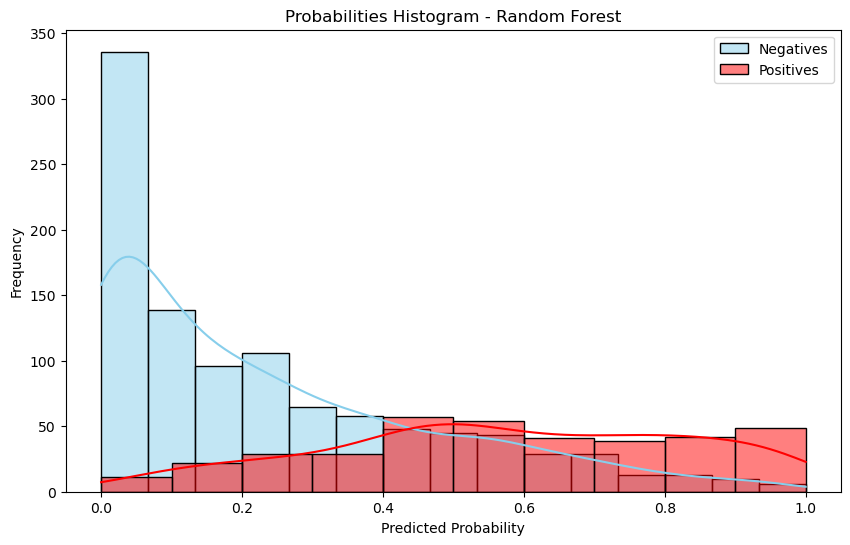

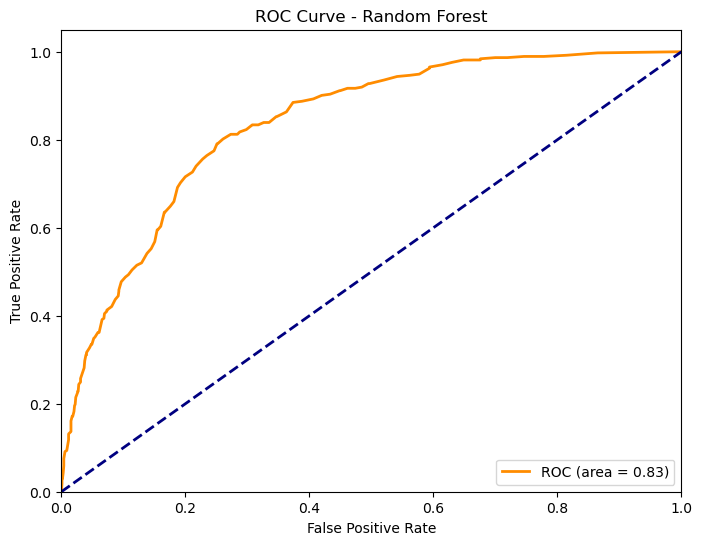

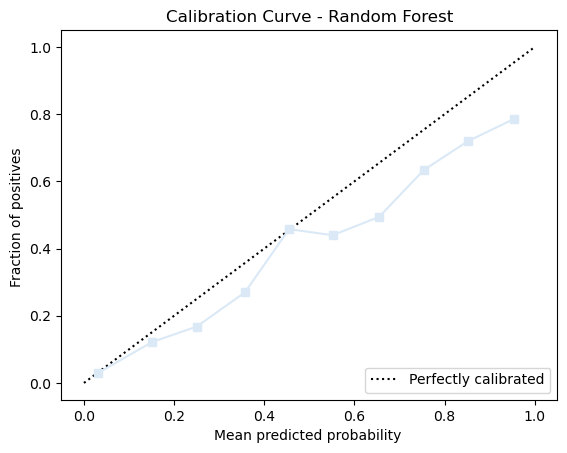

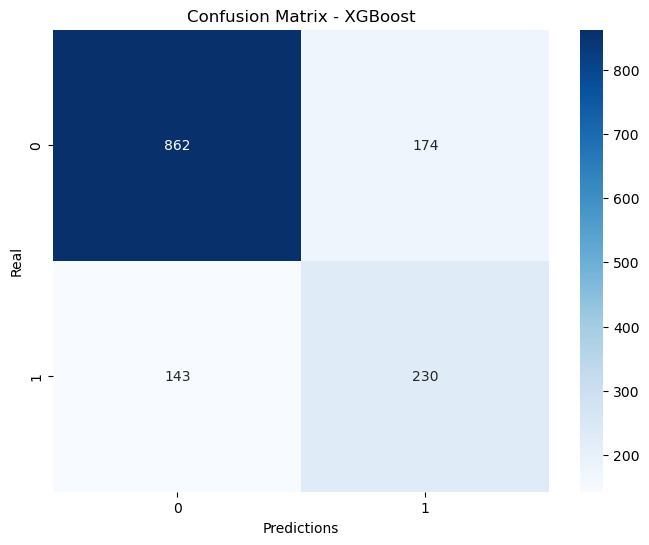

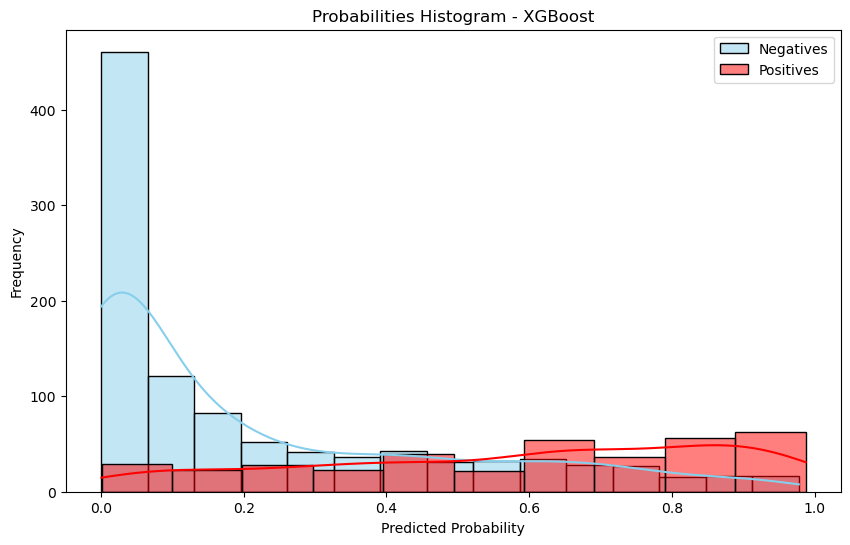

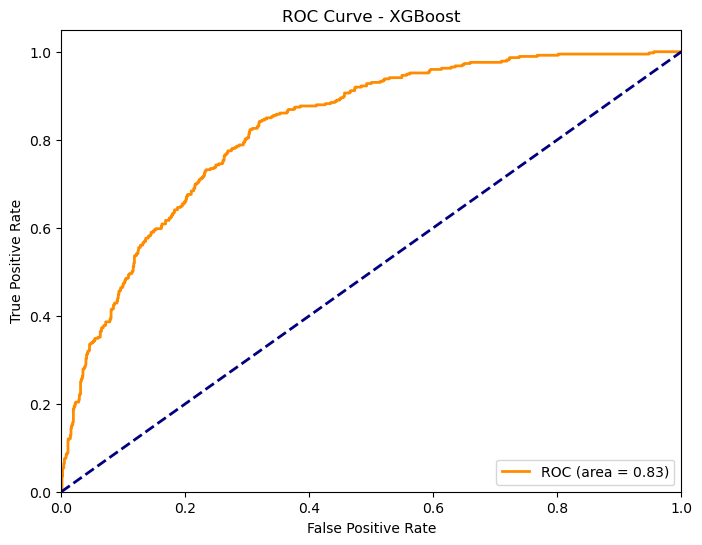

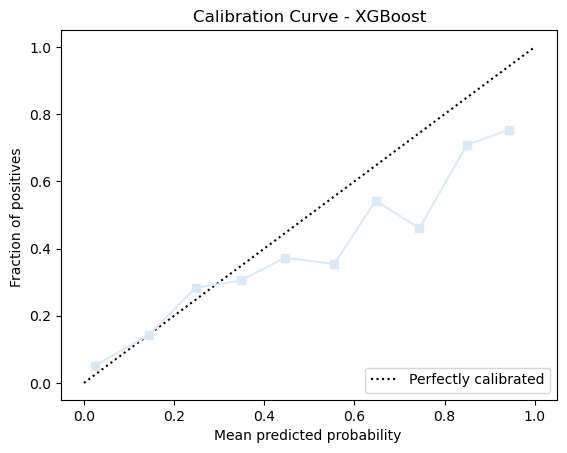

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


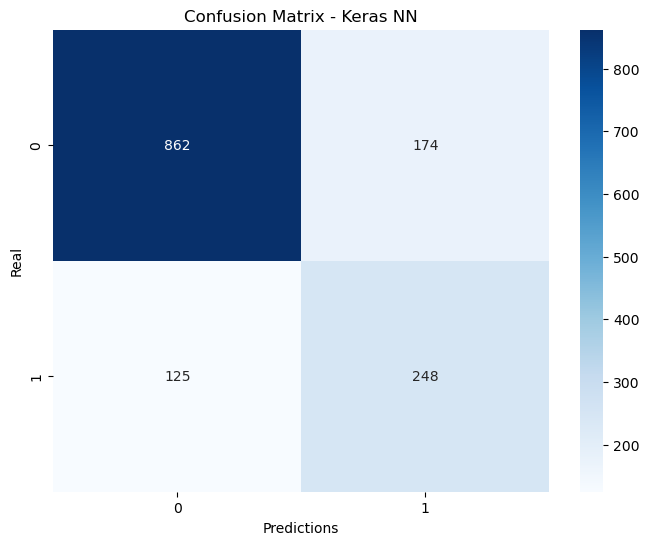

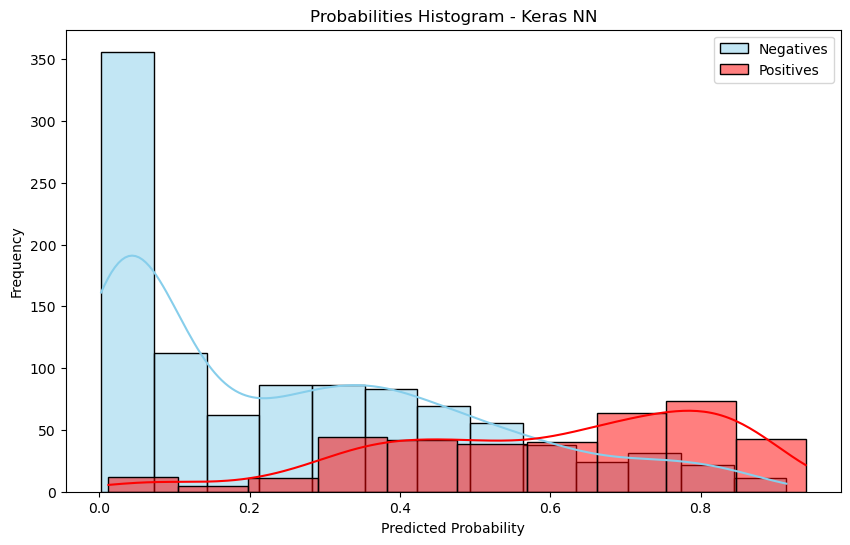

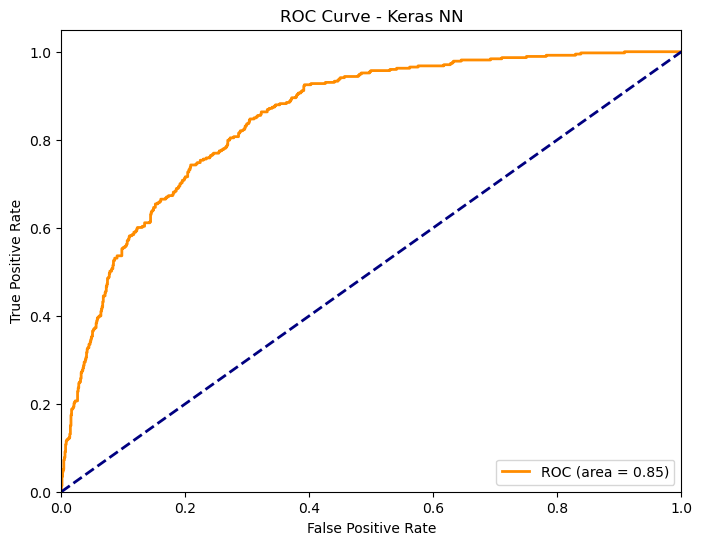

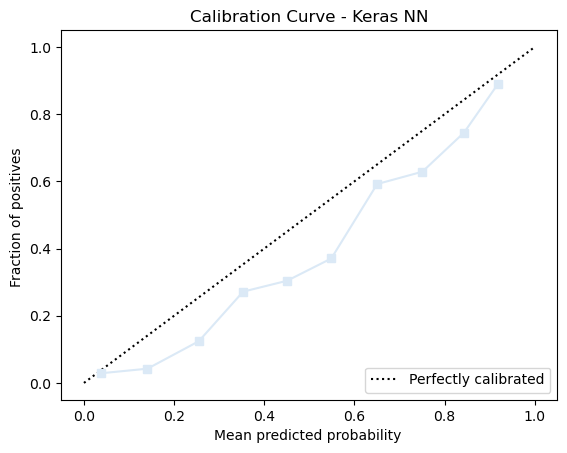

[I 2025-03-08 10:18:43,651] A new study created in memory with name: no-name-ec5cd51c-7ecd-46fa-8399-ab8ad0950233


Tabla Resumen de Métricas:
           Model  Accuracy    Recall  Precision        F1   ROC_AUC     Brier  \
0  Random Forest  0.778566  0.595174   0.579634  0.587302  0.834753  0.145479   
1        XGBoost  0.775018  0.616622   0.569307  0.592021  0.826552  0.152213   
2       Keras NN  0.787793  0.664879   0.587678  0.623899  0.849169  0.143054   

       Time  
0  0.783407  
1  0.131297  
2  8.565510  
Comparación de victorias: {'Random Forest': 0, 'XGBoost': 0, 'Keras NN': 3}
El mejor modelo seleccionado es: Keras NN
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:19:03,845] Trial 0 finished with value: 0.8458069808606002 and parameters: {'n_hidden': 1, 'n_neurons': 70, 'dropout_rate': 0.4093111568286576, 'learning_rate': 0.0006215955690186707, 'epochs': 50}. Best is trial 0 with value: 0.8458069808606002.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:19:13,667] Trial 1 finished with value: 0.8476676120777997 and parameters: {'n_hidden': 2, 'n_neurons': 38, 'dropout_rate': 0.13785231144925675, 'learning_rate': 0.0012163098935384698, 'epochs': 18}. Best is trial 1 with value: 0.8476676120777997.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:19:24,734] Trial 2 finished with value: 0.8516605939528191 and parameters: {'n_hidden': 3, 'n_neurons': 25, 'dropout_rate': 0.26944155643787493, 'learning_rate': 0.0005101922582306781, 'epochs': 21}. Best is trial 2 with value: 0.8516605939528191.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:19:32,748] Trial 3 finished with value: 0.8439152959930439 and parameters: {'n_hidden': 1, 'n_neurons': 58, 'dropout_rate': 0.20161987763185701, 'learning_rate': 0.003640512589064587, 'epochs': 14}. Best is trial 2 with value: 0.8516605939528191.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-03-08 10:20:05,638] Trial 4 finished with value: 0.847075004916828 and parameters: {'n_hidden': 2, 'n_neurons': 41, 'dropout_rate': 0.011272708741874637, 'learning_rate': 0.0005901416389969393, 'epochs': 43}. Best is trial 2 with value: 0.8516605939528191.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-03-08 10:20:18,838] Trial 5 finished with value: 0.848027316861097 and parameters: {'n_hidden': 3, 'n_neurons': 80, 'dropout_rate': 0.1577456245136215, 'learning_rate': 0.0004396069951647044, 'epochs': 11}. Best is trial 2 with value: 0.8516605939528191.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-03-08 10:20:40,480] Trial 6 finished with value: 0.8302465142277474 and parameters: {'n_hidden': 2, 'n_neurons': 98, 'dropout_rate': 0.19171911293681076, 'learning_rate': 0.006464572058951354, 'epochs': 26}. Best is trial 2 with value: 0.8516605939528191.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:21:12,839] Trial 7 finished with value: 0.8492720506795574 and parameters: {'n_hidden': 2, 'n_neurons': 70, 'dropout_rate': 0.26383110341853777, 'learning_rate': 0.00021315126823892523, 'epochs': 45}. Best is trial 2 with value: 0.8516605939528191.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:21:26,120] Trial 8 finished with value: 0.8512853623443435 and parameters: {'n_hidden': 1, 'n_neurons': 79, 'dropout_rate': 0.06864896570670254, 'learning_rate': 0.0002460231941694176, 'epochs': 20}. Best is trial 2 with value: 0.8516605939528191.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-03-08 10:21:44,033] Trial 9 finished with value: 0.8454498638814991 and parameters: {'n_hidden': 3, 'n_neurons': 73, 'dropout_rate': 0.18951135021429583, 'learning_rate': 0.001426724355326384, 'epochs': 18}. Best is trial 2 with value: 0.8516605939528191.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-03-08 10:22:10,846] Trial 10 finished with value: 0.8493600360222344 and parameters: {'n_hidden': 3, 'n_neurons': 16, 'dropout_rate': 0.3301079890358917, 'learning_rate': 0.00010311513043482064, 'epochs': 34}. Best is trial 2 with value: 0.8516605939528191.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:22:25,546] Trial 11 finished with value: 0.8530683594356517 and parameters: {'n_hidden': 1, 'n_neurons': 128, 'dropout_rate': 0.052174820102810354, 'learning_rate': 0.00022851294743563323, 'epochs': 25}. Best is trial 11 with value: 0.8530683594356517.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-03-08 10:22:44,161] Trial 12 finished with value: 0.8538395250861739 and parameters: {'n_hidden': 1, 'n_neurons': 127, 'dropout_rate': 0.32735746280015504, 'learning_rate': 0.0001047566713870671, 'epochs': 29}. Best is trial 12 with value: 0.8538395250861739.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:23:05,930] Trial 13 finished with value: 0.8525611498131606 and parameters: {'n_hidden': 1, 'n_neurons': 127, 'dropout_rate': 0.42580637159176515, 'learning_rate': 0.00018396551354062243, 'epochs': 32}. Best is trial 12 with value: 0.8538395250861739.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:23:24,140] Trial 14 finished with value: 0.8536454397714451 and parameters: {'n_hidden': 1, 'n_neurons': 127, 'dropout_rate': 0.3608800695084992, 'learning_rate': 0.00012449174073055435, 'epochs': 27}. Best is trial 12 with value: 0.8538395250861739.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:23:46,946] Trial 15 finished with value: 0.8536532031840343 and parameters: {'n_hidden': 1, 'n_neurons': 110, 'dropout_rate': 0.35254044521560607, 'learning_rate': 0.0001153074394457316, 'epochs': 38}. Best is trial 12 with value: 0.8538395250861739.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:24:09,955] Trial 16 finished with value: 0.8431648327760928 and parameters: {'n_hidden': 1, 'n_neurons': 107, 'dropout_rate': 0.4841090033111461, 'learning_rate': 0.0025891737397608634, 'epochs': 37}. Best is trial 12 with value: 0.8538395250861739.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:24:34,719] Trial 17 finished with value: 0.8477426583994947 and parameters: {'n_hidden': 2, 'n_neurons': 110, 'dropout_rate': 0.3196489669291721, 'learning_rate': 0.00031276609970895807, 'epochs': 39}. Best is trial 12 with value: 0.8538395250861739.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:24:47,059] Trial 18 finished with value: 0.853213276470649 and parameters: {'n_hidden': 1, 'n_neurons': 94, 'dropout_rate': 0.3909161619420729, 'learning_rate': 0.00013398208391444236, 'epochs': 31}. Best is trial 12 with value: 0.8538395250861739.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:25:02,132] Trial 19 finished with value: 0.8457914540354219 and parameters: {'n_hidden': 1, 'n_neurons': 109, 'dropout_rate': 0.4820853720226606, 'learning_rate': 0.0008211001918143468, 'epochs': 39}. Best is trial 12 with value: 0.8538395250861739.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:25:17,978] Trial 20 finished with value: 0.8479755607771694 and parameters: {'n_hidden': 2, 'n_neurons': 115, 'dropout_rate': 0.3058042245440816, 'learning_rate': 0.00036900944775065654, 'epochs': 35}. Best is trial 12 with value: 0.8538395250861739.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:25:28,883] Trial 21 finished with value: 0.852361888890039 and parameters: {'n_hidden': 1, 'n_neurons': 120, 'dropout_rate': 0.35914295371899396, 'learning_rate': 0.00010294825307491441, 'epochs': 27}. Best is trial 12 with value: 0.8538395250861739.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:25:40,500] Trial 22 finished with value: 0.8540543128344736 and parameters: {'n_hidden': 1, 'n_neurons': 98, 'dropout_rate': 0.37467859090489336, 'learning_rate': 0.00015218356018388028, 'epochs': 28}. Best is trial 22 with value: 0.8540543128344736.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:25:50,440] Trial 23 finished with value: 0.852328247435486 and parameters: {'n_hidden': 1, 'n_neurons': 96, 'dropout_rate': 0.45082230545374474, 'learning_rate': 0.0001473927559766501, 'epochs': 23}. Best is trial 22 with value: 0.8540543128344736.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:26:07,393] Trial 24 finished with value: 0.8529493204426181 and parameters: {'n_hidden': 1, 'n_neurons': 89, 'dropout_rate': 0.3774410613979446, 'learning_rate': 0.000164090303720504, 'epochs': 43}. Best is trial 22 with value: 0.8540543128344736.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:26:19,291] Trial 25 finished with value: 0.8498931236866893 and parameters: {'n_hidden': 1, 'n_neurons': 103, 'dropout_rate': 0.3036107017289771, 'learning_rate': 0.00030373835911640443, 'epochs': 30}. Best is trial 22 with value: 0.8540543128344736.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:26:34,865] Trial 26 finished with value: 0.8506953429875681 and parameters: {'n_hidden': 2, 'n_neurons': 117, 'dropout_rate': 0.4379811680538635, 'learning_rate': 0.0001010249963566545, 'epochs': 34}. Best is trial 22 with value: 0.8540543128344736.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:26:46,603] Trial 27 finished with value: 0.8525792644425353 and parameters: {'n_hidden': 1, 'n_neurons': 86, 'dropout_rate': 0.2418240084694082, 'learning_rate': 0.00016483078320439512, 'epochs': 29}. Best is trial 22 with value: 0.8540543128344736.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:27:03,501] Trial 28 finished with value: 0.840587379796495 and parameters: {'n_hidden': 1, 'n_neurons': 119, 'dropout_rate': 0.3480408962769845, 'learning_rate': 0.0017117363596463161, 'epochs': 38}. Best is trial 22 with value: 0.8540543128344736.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-03-08 10:27:22,922] Trial 29 finished with value: 0.834490513109816 and parameters: {'n_hidden': 1, 'n_neurons': 103, 'dropout_rate': 0.40297923996504204, 'learning_rate': 0.009167204442082752, 'epochs': 50}. Best is trial 22 with value: 0.8540543128344736.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:27:40,490] Trial 30 finished with value: 0.8395419069011563 and parameters: {'n_hidden': 2, 'n_neurons': 60, 'dropout_rate': 0.28490084178944985, 'learning_rate': 0.0008439146882876982, 'epochs': 42}. Best is trial 22 with value: 0.8540543128344736.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:27:51,969] Trial 31 finished with value: 0.8552188247228462 and parameters: {'n_hidden': 1, 'n_neurons': 125, 'dropout_rate': 0.3693034730181424, 'learning_rate': 0.0001275821478625957, 'epochs': 28}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:28:03,579] Trial 32 finished with value: 0.853037305785295 and parameters: {'n_hidden': 1, 'n_neurons': 121, 'dropout_rate': 0.3966386130148638, 'learning_rate': 0.0002593381465728607, 'epochs': 24}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-03-08 10:28:23,390] Trial 33 finished with value: 0.8517899841626383 and parameters: {'n_hidden': 1, 'n_neurons': 113, 'dropout_rate': 0.3365893276509831, 'learning_rate': 0.00013579824246096227, 'epochs': 32}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-03-08 10:28:45,100] Trial 34 finished with value: 0.853104588694401 and parameters: {'n_hidden': 1, 'n_neurons': 122, 'dropout_rate': 0.22598026802477672, 'learning_rate': 0.00019065530894798134, 'epochs': 29}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:29:01,678] Trial 35 finished with value: 0.8468058732804041 and parameters: {'n_hidden': 1, 'n_neurons': 103, 'dropout_rate': 0.27926039801928504, 'learning_rate': 0.00041939308499494896, 'epochs': 22}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:29:17,998] Trial 36 finished with value: 0.8517123500367468 and parameters: {'n_hidden': 1, 'n_neurons': 114, 'dropout_rate': 0.45146448791662575, 'learning_rate': 0.0001213670583652501, 'epochs': 28}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:29:29,962] Trial 37 finished with value: 0.8516994110157649 and parameters: {'n_hidden': 2, 'n_neurons': 44, 'dropout_rate': 0.3712731061988718, 'learning_rate': 0.0005416168649743124, 'epochs': 16}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:29:49,791] Trial 38 finished with value: 0.8525740888341427 and parameters: {'n_hidden': 1, 'n_neurons': 90, 'dropout_rate': 0.41150911232316856, 'learning_rate': 0.0001832631436635259, 'epochs': 36}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:30:11,056] Trial 39 finished with value: 0.84735966337843 and parameters: {'n_hidden': 2, 'n_neurons': 123, 'dropout_rate': 0.3008455172581, 'learning_rate': 0.0002966395968176059, 'epochs': 32}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:30:35,443] Trial 40 finished with value: 0.8523101328061113 and parameters: {'n_hidden': 1, 'n_neurons': 60, 'dropout_rate': 0.23550025072847608, 'learning_rate': 0.00022003848572890679, 'epochs': 47}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-08 10:30:50,261] Trial 41 finished with value: 0.8550816711004379 and parameters: {'n_hidden': 1, 'n_neurons': 128, 'dropout_rate': 0.3529358034761807, 'learning_rate': 0.000124445213697148, 'epochs': 26}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:31:06,278] Trial 42 finished with value: 0.8521367499249538 and parameters: {'n_hidden': 1, 'n_neurons': 127, 'dropout_rate': 0.3359652435612811, 'learning_rate': 0.00013356303678119447, 'epochs': 26}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:31:20,815] Trial 43 finished with value: 0.8511404453093461 and parameters: {'n_hidden': 1, 'n_neurons': 108, 'dropout_rate': 0.3775757654894001, 'learning_rate': 0.0001177446763506859, 'epochs': 24}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:31:33,790] Trial 44 finished with value: 0.8537178982889437 and parameters: {'n_hidden': 1, 'n_neurons': 116, 'dropout_rate': 0.26578808769994033, 'learning_rate': 0.00015531403629070128, 'epochs': 21}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2025-03-08 10:31:51,394] Trial 45 finished with value: 0.847432121895929 and parameters: {'n_hidden': 3, 'n_neurons': 122, 'dropout_rate': 0.21323404337532015, 'learning_rate': 0.0001612468803805556, 'epochs': 20}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:32:06,520] Trial 46 finished with value: 0.8518857329179045 and parameters: {'n_hidden': 1, 'n_neurons': 117, 'dropout_rate': 0.14946351162439345, 'learning_rate': 0.00020424782576229755, 'epochs': 17}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:32:17,045] Trial 47 finished with value: 0.8406417236846192 and parameters: {'n_hidden': 1, 'n_neurons': 128, 'dropout_rate': 0.26832200810003654, 'learning_rate': 0.004611691760986042, 'epochs': 11}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-08 10:32:33,937] Trial 48 finished with value: 0.849357448218038 and parameters: {'n_hidden': 1, 'n_neurons': 100, 'dropout_rate': 0.12183790982122183, 'learning_rate': 0.00027299852458952947, 'epochs': 21}. Best is trial 31 with value: 0.8552188247228462.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2025-03-08 10:32:56,983] Trial 49 finished with value: 0.8506539381204261 and parameters: {'n_hidden': 2, 'n_neurons': 124, 'dropout_rate': 0.31485402076438523, 'learning_rate': 0.00015201336036702672, 'epochs': 25}. Best is trial 31 with value: 0.8552188247228462.


Mejores hiperparámetros:
{'n_hidden': 1, 'n_neurons': 125, 'dropout_rate': 0.3693034730181424, 'learning_rate': 0.0001275821478625957, 'epochs': 28}
Mejor ROC AUC: 0.8552
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Tabla de métricas del mejor modelo optimizado:
     Modelo  Accuracy    Recall  Precision        F1   ROC_AUC     Brier  \
0  Keras NN  0.787083  0.691689   0.582393  0.632353  0.852936  0.140906   

      Tiempo  
0  17.472822  


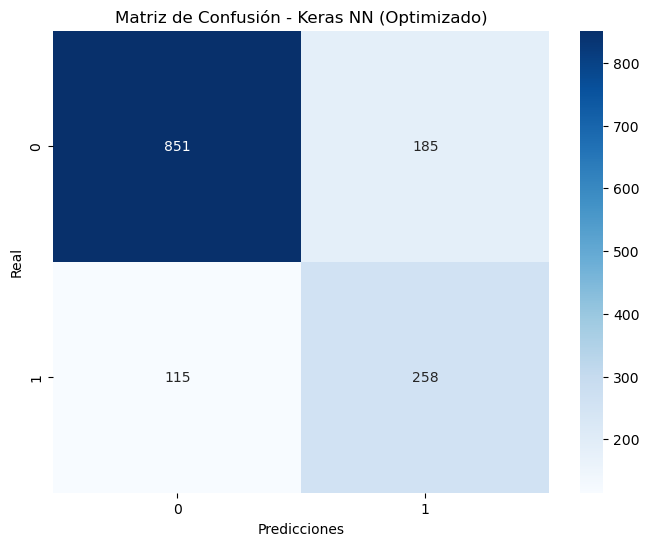

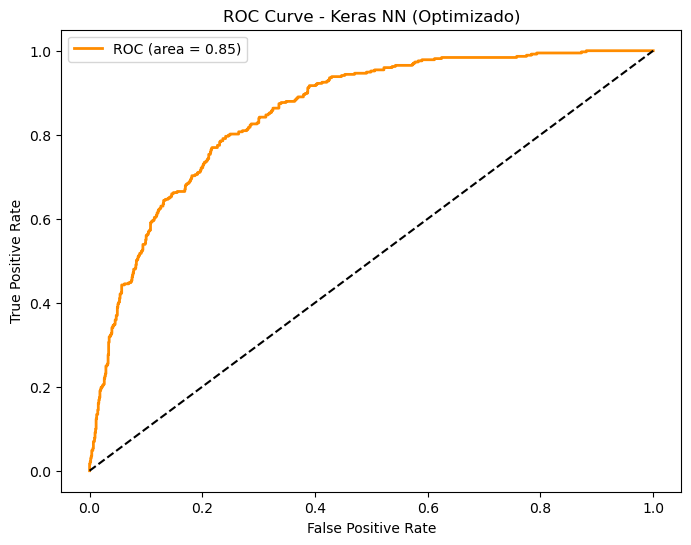

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


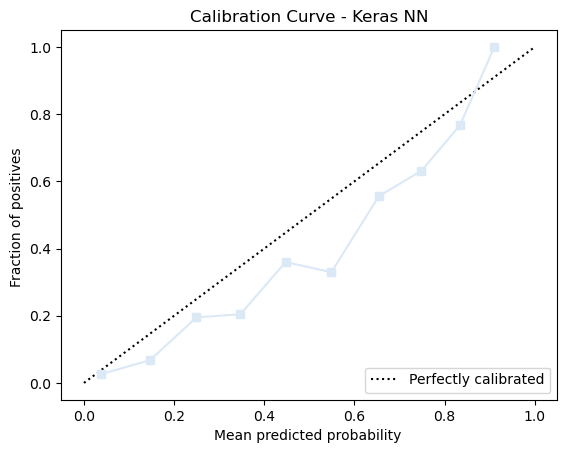

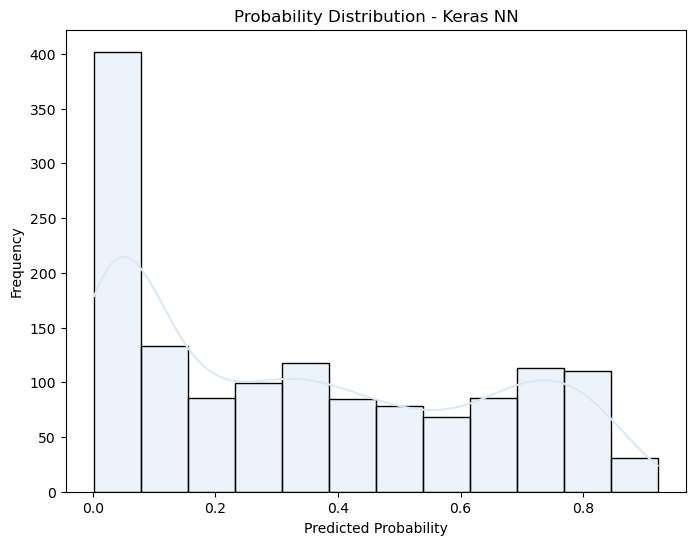

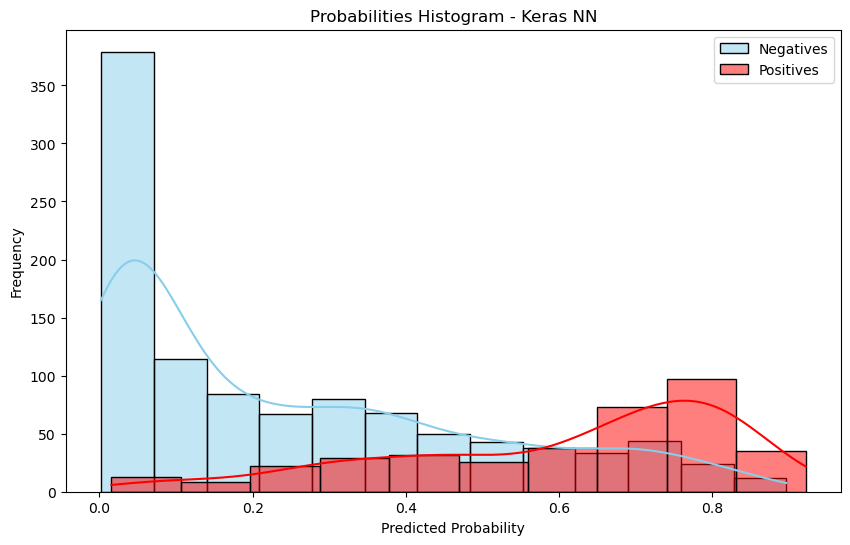

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1036
           1       0.58      0.69      0.63       373

    accuracy                           0.79      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.79      0.79      1409



In [ ]:

# 1. Train and evaluate Random Forest
rf = RandomForestClassifier()
metrics_rf = train_and_evaluate_model(rf, 'Random Forest', X_train_res, y_res, X_test, y_test)

# 2. Train and evaluate XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
metrics_xgb = train_and_evaluate_model(xgb_model, 'XGBoost', X_train_res, y_res, X_test, y_test)

# 3. Train and evaluate Keras Neural Network
input_dim = X_train_res.shape[1]
keras_model = build_keras_model(n_hidden=2, n_neurons=32, dropout_rate=0.2, learning_rate=0.001, input_dim=input_dim)
metrics_keras = train_and_evaluate_model(keras_model, 'Keras NN', X_train_res, y_res, X_test, y_test, is_keras=True, epochs=20)

# Create a metrics summary table
metrics_df = pd.DataFrame([metrics_rf, metrics_xgb, metrics_keras])
print("Tabla Resumen de Métricas:")
print(metrics_df)

# Selecting the best model based on metrics and execution time
best_model, wins = select_best_model(metrics_df)
print("Comparación de victorias:", wins)
print("El mejor modelo seleccionado es:", best_model)

# Create the study and optimize using the objective function for the selected model
objective_func = get_objective(best_model, X_train_res, y_res, X_test, y_test)
study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=50)

print("Mejores hiperparámetros:")
print(study.best_params)
print(f"Mejor ROC AUC: {study.best_value:.4f}")

# --- Train the optimized model ---
if best_model == 'Random Forest':
    best_model_optimized = RandomForestClassifier(**study.best_params)
elif best_model == 'XGBoost':
    best_model_optimized = xgb.XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric='logloss')
elif best_model == 'Keras NN':
    input_dim = X_train_res.shape[1]
    best_model_optimized = build_keras_model(
        n_hidden=study.best_params.get('n_hidden', 2),
        n_neurons=study.best_params.get('n_neurons', 32),
        dropout_rate=study.best_params.get('dropout_rate', 0.2),
        learning_rate=study.best_params.get('learning_rate', 0.001),
        input_dim=input_dim)
    best_epochs = study.best_params.get('epochs', 20)

# Measure the training time of the optimized model
start_time = time.time()
if best_model == 'Keras NN':
    best_model_optimized.fit(X_train_res, y_res, epochs=best_epochs, verbose=0)
else:
    best_model_optimized.fit(X_train_res, y_res)
training_time_optimized = time.time() - start_time

# Predictions and probabilities on the test set
if hasattr(best_model_optimized, "predict_proba"):
    y_pred_opt_prob = best_model_optimized.predict_proba(X_test)[:, 1]
else:
    y_pred_opt_prob = best_model_optimized.predict(X_test).ravel()
y_pred_opt = (y_pred_opt_prob > 0.5).astype(int)

# Calculate the evaluation metrics of the optimized model
metrics_optimized = {
    "Modelo": best_model,
    "Accuracy": accuracy_score(y_test, y_pred_opt),
    "Recall": recall_score(y_test, y_pred_opt),
    "Precision": precision_score(y_test, y_pred_opt),
    "F1": f1_score(y_test, y_pred_opt),
    "ROC_AUC": roc_auc_score(y_test, y_pred_opt_prob),
    "Brier": brier_score_loss(y_test, y_pred_opt_prob),
    "Tiempo": training_time_optimized
}

# Create the metrics table in a DataFrame
df_metrics_optimized = pd.DataFrame([metrics_optimized])
print("Tabla de métricas del mejor modelo optimizado:")
print(df_metrics_optimized)

# Plot confusion matrix of the best model
conf_matrix_opt = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_opt, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión - {best_model} (Optimizado)')
plt.xlabel('Predicciones')
plt.ylabel('Real')
plt.show()

# Plot ROC curve of the best model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_opt_prob)
roc_auc_val = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model} (Optimizado)')
plt.legend()
plt.show()


# Obtaining predictions and probabilities
if hasattr(best_model_optimized, "predict_proba"):
        y_pred_prob = best_model_optimized.predict_proba(X_test)[:, 1]
else:
        # For Keras models, we use predict and flatten the result
        y_pred_prob = best_model_optimized.predict(X_test).ravel()

 # Fixed threshold of 0.5 for classification
y_pred = (y_pred_prob > 0.5).astype(int)

# Plot Calibration curve of the best model
prob_true, prob_pred = calibration_curve(y_test, y_pred_opt_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_pred_opt_prob)
disp.plot()
plt.title(f'Calibration Curve - {best_model}')
plt.show()

# Plot probability distribution of the best model
plt.figure(figsize=(8,6))
sns.histplot(y_pred_opt_prob, kde=True)
plt.title(f'Probability Distribution - {best_model}')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()


# Plot probability distribution of the best model by class
plt.figure(figsize=(10,6))
sns.histplot(y_pred_opt_prob[y_test==0], color='skyblue', kde=True, label='Negatives')
sns.histplot(y_pred_opt_prob[y_test==1], color='red', kde=True, label='Positives')
plt.title(f'Probabilities Histogram - {best_model}')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Classification report of the best model
print(classification_report(y_test, y_pred))

# Save the best model to a pickle file
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model_optimized, file)

Prior to hyperparameter optimization with Optuna, it was found that the baseline neural network model exhibited higher precision and recall, which also resulted in a higher F1 score. Similarly, its ROC AUC value was the highest among the three baseline models, and its Brier Score was the lowest, making it the winning model among the options.

The calibration curve of the neural network model also demonstrated better performance by being closer to the perfect calibration curve compared to the other two models. This indicates that as the predicted probability increases, the fraction of positive cases (churners) increases almost proportionally.

After applying hyperparameter optimization with Optuna, it was found that not only did the ROC AUC increase, but recall also increased, causing F1 to increase too and the Brier Score decreased.


## Cross Validation

In [8]:
run_cross_validation(best_model, study, X_train_res, y_res)


INFO:root:Running cross-validation for Keras NN...
INFO:root:Cross validation process ended for Keras NN.


ROC AUC por fold (Keras NN): [0.83919695 0.82779663 0.84072437 0.83776374 0.87727599]
ROC AUC promedio (Keras NN): 0.8446


array([0.83919695, 0.82779663, 0.84072437, 0.83776374, 0.87727599])

The model is stable, as it exhibits consistent and robust ROC AUC metrics across 5 cross-validation folds.


## Feature Importances

PermutationExplainer explainer: 1410it [01:41, 12.52it/s]                          


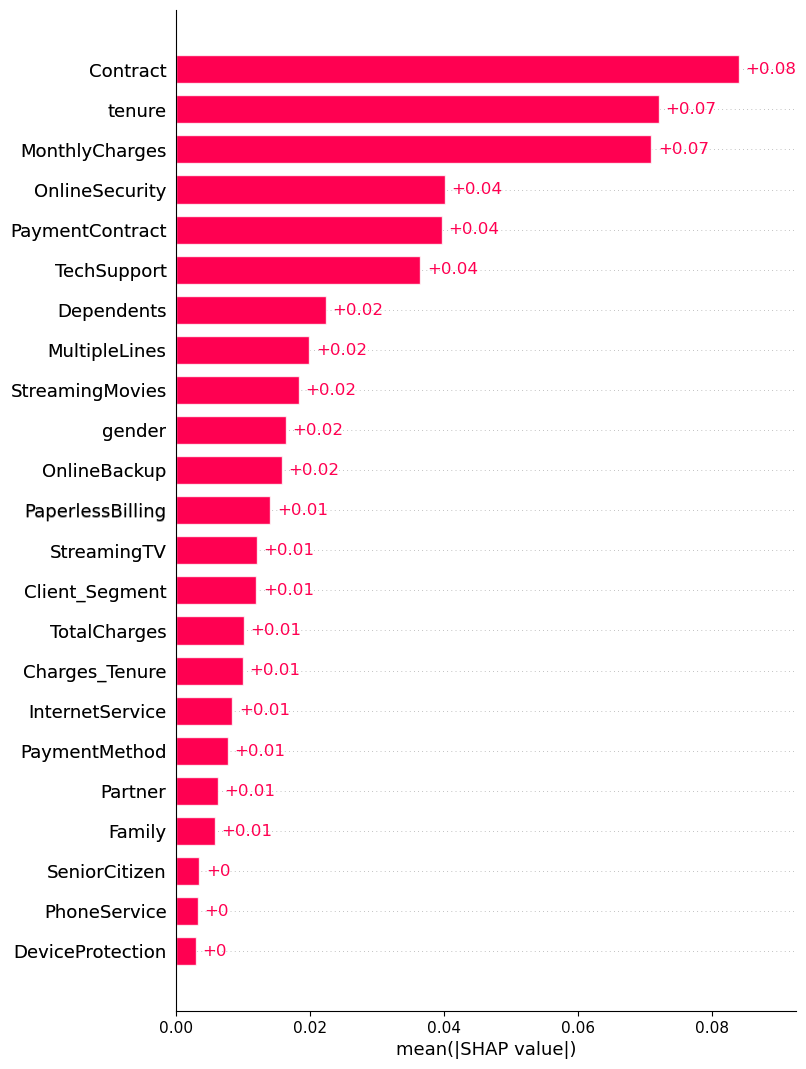

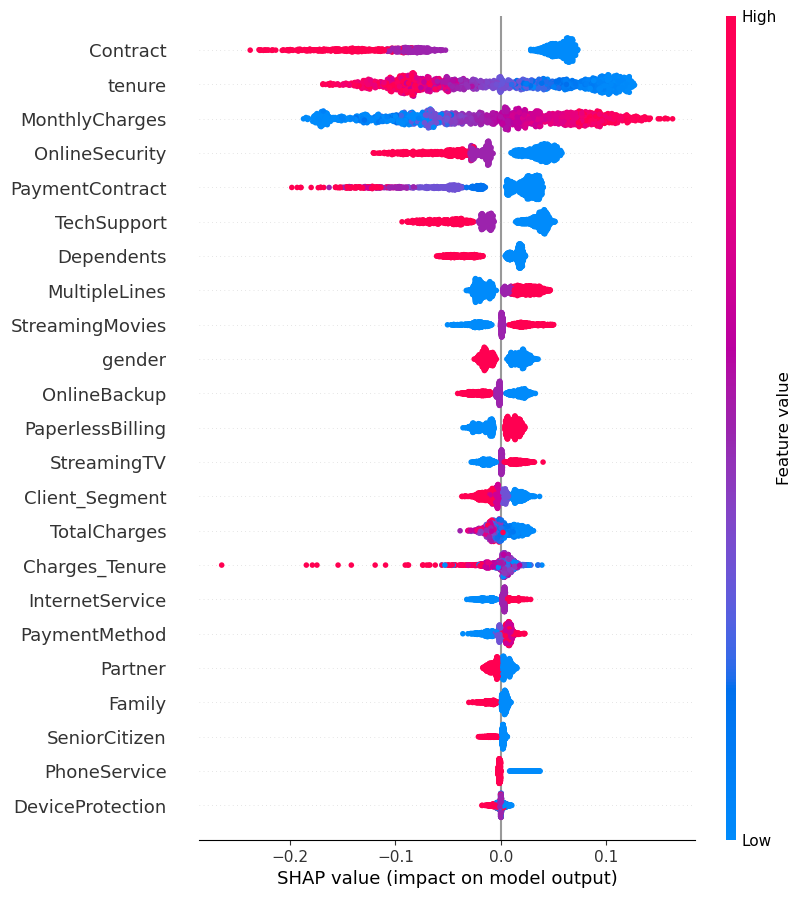

In [9]:
plot_feature_importances_or_shap(best_model, best_model_optimized, X_train_res, X_test)

## Additional Analysis

According to the findings in the Feature Importances section, the hypothesis formed during the exploratory data analysis is confirmed: the type of contract a customer has influences their likelihood of churning, as does the amount paid per month and their level of seniority.

The variables created from PaymentContract and Client_Segment had a significant impact on the explainability of churn, whereas the SeniorCitizen and PhoneService variables did not contribute to the probability of churn and can even be discarded from the model.

A good way to retain customers might be by offering annual plans at a discounted price compared to the original rate for the first year, and then charging the normal price from the second year onward; surely, the customer won't leave even after being charged for the second payment.

In the future, it would be worthwhile to specifically identify the cost of retaining a customer who never really intended to leave, thereby providing a clearer perspective on the preference between metrics such as precision or recall.